## Reconstruction of Auditory Stiumulus Envelope From EEG Using GAN
Here we train GAN that learns to synthesize audio heard by the participant during EEG recording. Unlike a vanilla GAN, this GAN is conditioned not on random input, but on EEG recorded as the participant was listening to a audio stumulus. Another key difference from a vanilla GAN is that has not just an adversarial loss, but also a feature loss (pearson's R in our case). In this GAN the generator (here called encoder), we use a very lightweight model with depthwise separable convolutions (that filter each channel individually) that thanks to a depthwise_multiplier parameter produce not just one filtered output channel per each input channel, but as many as we want (we want just 1 in our case) without mixing adjacent channels during the convolution. Then we take a weighted sum of the filtered channels using a 1x1 convolution. The overall objective of the GAN is to generate from EEG some output with as high correlation with the true audio envelope as possible. We can see that the network starts overfitting moderately at around Epoch 16. This addition of an adversarial loss is a major improvement over what we had one year ago.

In [1]:
normalize = 1
T = 200

# get the Dataset:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio

# load data from the .mat file:
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/EEG_data.mat') # or ('EEG_data.mat')
mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/DAS_CH_AVG_500Hz_2.mat, DS2=100Hz, FIR=1-40Hz, centnorm=1, Env=1, TD, 1-124.mat')
X = mat_contents['X']
Y = mat_contents['Y']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
print('Original data type:', x_train.dtype)

# convert to float64 for numerical stability:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')

if normalize==1:
    # normalize to unit variance and zero mean:
    for i in range(x_train.shape[0]):
        x_train[i,:,:] = preprocessing.scale(x_train[i,:,:], axis=1)
        x_train[i,:,:] = preprocessing.minmax_scale(x_train[i,:,:], axis=1)
        y_train[i,:] = preprocessing.scale(y_train[i,:], axis=0)
        y_train[i,:] = preprocessing.minmax_scale(y_train[i,:], axis=0)

    for i in range(x_test.shape[0]):
        x_test[i,:,:] = preprocessing.scale(x_test[i,:,:], axis=1)
        x_test[i,:,:] = preprocessing.minmax_scale(x_test[i,:,:], axis=1)
        y_test[i,:] = preprocessing.scale(y_test[i,:], axis=0)
        y_test[i,:] = preprocessing.minmax_scale(y_test[i,:], axis=0)

# ensure the tensors are sized right:
x_train = np.expand_dims(x_train,3).squeeze().transpose(0,2,1)
x_test = np.expand_dims(x_test,3).squeeze().transpose(0,2,1)
y_test = np.expand_dims(y_test,1).transpose(0,2,1)
# y_test = y_test[:,:,:,None]
y_train = np.expand_dims(y_train,1).transpose(0,2,1)
# y_train = y_train[:,:,:,None]

# convert to float16 to save space:
x_train = x_train.astype('float16')
y_train = y_train.astype('float16')
x_test = x_test.astype('float16')
y_test = y_test.astype('float16')
print('Normalized data type:', x_train.dtype)


print('test input shape', x_test.shape, "Normalized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
print('train input shape', x_train.shape, "Normalized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

print('test labels shape', y_test.shape, "Normalized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
print('train labels shape', y_train.shape, "Normalized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

Original data type: float32
Normalized data type: float16
test input shape (360, 200, 63) Normalized MEAN: 0.5005 min 0.0 max 1.0
train input shape (840, 200, 63) Normalized MEAN: 0.501 min 0.0 max 1.0
test labels shape (360, 200, 1) Normalized MEAN: 0.2766 min 0.0 max 1.0
train labels shape (840, 200, 1) Normalized MEAN: 0.2834 min 0.0 max 1.0


In [2]:
# make sure you don't hog all the video memory
import os
import time
import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"]="3"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
###################################

from keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, UpSampling2D, SeparableConv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras import backend as K
from keras.models import load_model
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import csv
import datetime
import os.path
import mne
import pickle

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

def best_performer(x, y, encoder, mode):
    reconst = encoder.predict(x).squeeze()
    orig = y.squeeze()
    RR = []
    for samp in range(y.shape[0]):
        R,p = pearsonr(reconst[samp], orig[samp])
        RR.append(R)

    loc = np.where(np.abs(RR)==np.max(np.abs(RR)))[0][0]
    rec = preprocessing.minmax_scale(reconst[loc,:]-np.min(reconst[loc,:]))

    plt.subplot(1,2,1 if mode=='train' else 2)
    plt.plot(rec)
    plt.plot(preprocessing.minmax_scale(orig[loc,:]))
    plt.tight_layout()
    plt.grid()
    plt.axhline(np.mean(RR), alpha=0.25)
    plt.text(0, np.mean(RR)+0.02, 'Average correlation')
    plt.legend (['Reconstructed Envelope', 'Original Envelope'])
    plt.title ('Best reconstruction (' + mode +')')

class GAN():
    def __init__(self):
        self.discriminator = self.Discriminator()
        sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
        self.discriminator.compile(optimizer='adam', loss='binary_crossentropy')
        self.encoder = self.Encoder()
        self.encoder.compile(optimizer='adam', loss=self.correlation_coefficient_loss)
        self.timestamp = datetime.datetime.now()
        self.discriminator_epochs = []
        self.encoder_epochs = []
        self.last_epoch = 0
        self.feature_loss_weight = 1.0
        if os.path.isfile('PROGRESS.csv')==True:
            print('Appending progress to file PROGRESS.csv')
        else:
            self.log('R_train', 'R_test', 'mode', 'started', 'cycle') 
    
    def log(self, r_train, r_test, mode, stamp, cycle):
        # log performance to file:
        with open(r'PROGRESS.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow([r_train, r_test, mode, stamp, cycle]) # list of three elements
        
    def SoftMax(self, x):
        return K.tf.nn.softmax(x)

    def onehot(self, labels):
        out = np.zeros((len(labels),2))
        for i in range(len(labels)):
            if labels[i]<=0.5:
                out[i,0] = labels[i]
                out[i,1] = np.abs(labels[i]-1)
            if labels[i]>0.5:
                out[i,0] = labels[i]
                out[i,1] = np.abs(labels[i]-1)
        return out
    
    def check_progress(self, x_train, y_train, x_test, y_test):
        RR_train, RR_test = [], []
        decoded_train, decoded_test = self.encoder.predict(x_train), self.encoder.predict(x_test)
        reconst_train, reconst_test = decoded_train.squeeze(), decoded_test.squeeze()
        orig_train, orig_test = y_train.squeeze(), y_test.squeeze()
        for samp in range(y_train.shape[0]):
            R,p = pearsonr(reconst_train[samp], orig_train[samp])
            RR_train.append(R)
        for samp in range(y_test.shape[0]):
            R,p = pearsonr(reconst_test[samp], orig_test[samp])
            RR_test.append(R)
        return np.mean(RR_train), np.mean(RR_test)

    def correlation_coefficient_loss(self, y_true, y_pred):
        x = y_true
        y = y_pred
        mx = K.mean(x, axis=1, keepdims=True)
        my = K.mean(y, axis=1, keepdims=True)
        xm, ym = x-mx, y-my
        r_num = K.sum(tf.multiply(xm,ym))
        r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
        r = r_num / r_den
        r = K.maximum(K.minimum(r, 1.0), -1.0)
        return 1 - r

    def Encoder(self):
        input_img = Input(shape=(T, 63))  # adapt this if using `channels_first` image data format   
        e1 = SeparableConv1D(1, 100, activation='relu', padding='same', depth_multiplier=1)(input_img)
        e1 = BatchNormalization()(e1)
        return Model(input_img, e1, name='encoder')

    def Discriminator(self):
        input_img = Input(shape=(T, 1))  # adapt this if using `channels_first` image data format
        e1 = Conv1D(12, 50, activation='relu', padding='same')(input_img)
        e1 = Conv1D(24, 50, activation='relu', padding='same')(e1) #48
        e1 = MaxPooling1D(2)(e1)
        e1 = Flatten()(e1)
        e1 = Dense(48, activation='relu')(e1)
        e1 = Dense(2, activation=self.SoftMax)(e1)
        return Model(input_img, e1, name='discriminator')

    def FitDiscriminator(self, x, y, epochs=1, batch_size=10, verbose=0):
        # forward the generator to generate fakes:
        loss_before = np.mean(self.discriminator.predict(self.encoder.predict(x_train))[:,0]).item()
        fakes = self.encoder.predict(x)

        # make a tensor of fake and real images:
        reals = y
        soft_zeros = np.random.choice(np.arange(0, 0.1, 0.01), len(reals))
        soft_ones = np.random.choice(np.arange(0.9, 1.0, 0.01), len(fakes))
        
        batch_labels = np.concatenate([soft_zeros, soft_ones], axis=0)
        batch_images = np.concatenate([reals, fakes],axis=0)
        permutation_mask = np.random.choice(len(batch_images), len(batch_images), replace=False)
        batch_labels = batch_labels[permutation_mask]
        batch_images = batch_images[permutation_mask,:]
        
        # add 5% random noise to labels:
        b = np.random.choice(len(reals)*2, np.round(len(reals)*2*0.05).astype('int'), replace=False)
        for i in b:
            batch_labels[i] = np.abs(batch_labels[i]-1)
        

        # backward the discriminator
        h = self.discriminator.fit(batch_images, self.onehot(batch_labels),
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=verbose)

        self.discriminator_epochs.extend(np.arange(self.last_epoch, self.last_epoch + epochs).tolist())
        self.last_epoch += epochs
        h.history['loss'][0] = loss_before
        
        return h.history['loss']

    def FitEncoder(self, x, y, epochs=1, batch_size=10, verbose=0, loss_weights = [1, 1]):
        # freeze the weights fo the discriminator while we fit the Encoder
        self.discriminator.trainable = False

        # define a GAN:
        inpt = Input(shape=(T, 63))
        GAN_ = Model(inputs=inpt, outputs=[self.discriminator(self.encoder(inpt)), self.encoder(inpt)])

        # The GAN must have not just adversarial loss (as a minimum) but also include the feature loss:
        losses = ["binary_crossentropy", self.correlation_coefficient_loss]

        GAN_.compile(optimizer='adam', loss=losses, loss_weights=loss_weights)
        # make a vector of ones ('true' lables), because we want our generator to fool the discriminator into 
        # thinking that all the discriminator's outputs are real, not something generated.
        OH = np.repeat(1, len(x))

        # fit the GAN:
        h = GAN_.fit(x, [self.onehot(OH), y],
                        epochs=epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        verbose=verbose)
        self.discriminator.trainable = True
        self.encoder_epochs.extend(np.arange(self.last_epoch, self.last_epoch + epochs).tolist())
        self.last_epoch += epochs
        return h.history['encoder_loss']

Appending progress to file PROGRESS.csv
Cycle: -1	 Mean R_train: 0.05	 Mean R_test: 0.03	 elapsed: 24.43 seconds
Cycle: 0	 M R_tr: 0.07	 M R_te: 0.04	 t: 9.46	D_loss:0.49	E_loss:0.95
Cycle: 1	 M R_tr: 0.07	 M R_te: 0.04	 t: 8.69	D_loss:0.49	E_loss:0.94
Cycle: 2	 M R_tr: 0.07	 M R_te: 0.05	 t: 8.05	D_loss:0.48	E_loss:0.93
Cycle: 3	 M R_tr: 0.08	 M R_te: 0.05	 t: 8.73	D_loss:0.48	E_loss:0.92
Cycle: 4	 M R_tr: 0.09	 M R_te: 0.06	 t: 8.82	D_loss:0.48	E_loss:0.92
Cycle: 5	 M R_tr: 0.10	 M R_te: 0.06	 t: 8.50	D_loss:0.47	E_loss:0.91
Cycle: 6	 M R_tr: 0.09	 M R_te: 0.06	 t: 9.07	D_loss:0.47	E_loss:0.90
Cycle: 7	 M R_tr: 0.11	 M R_te: 0.07	 t: 8.84	D_loss:0.47	E_loss:0.89
Cycle: 8	 M R_tr: 0.12	 M R_te: 0.08	 t: 8.35	D_loss:0.47	E_loss:0.89
Cycle: 9	 M R_tr: 0.13	 M R_te: 0.08	 t: 9.08	D_loss:0.47	E_loss:0.88
Cycle: 10	 M R_tr: 0.12	 M R_te: 0.08	 t: 9.25	D_loss:0.47	E_loss:0.87
Cycle: 11	 M R_tr: 0.13	 M R_te: 0.09	 t: 9.15	D_loss:0.47	E_loss:0.86
Cycle: 12	 M R_tr: 0.13	 M R_te: 0.09	 t: 9.2

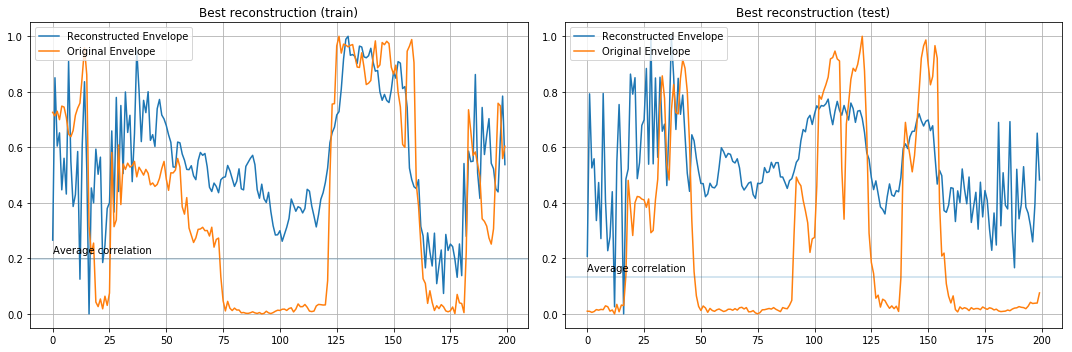

In [3]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)


EPOCHS = 100


gan = GAN()
discriminator_loss, encoder_loss = [],[]
t = time.time()
encoder_loss.extend(gan.FitEncoder(x_train, y_train, epochs=130, batch_size=400, verbose=0, loss_weights=[1, 1]))
avg_train, avg_test = gan.check_progress(x_train, y_train, x_test, y_test)
gan.log(avg_train, avg_test, 'adversarial', gan.timestamp, 0)
print('Cycle: {:.0f}\t Mean R_train: {:.2f}\t Mean R_test: {:.2f}\t elapsed: {:.2f} seconds'.format(-1, avg_train, avg_test, time.time() - t))
          
for i in range(EPOCHS):
    t = time.time()
    discriminator_loss.extend(gan.FitDiscriminator(x_train, y_train, epochs=4, batch_size=400, verbose=0))
    encoder_loss.extend(gan.FitEncoder(x_train, y_train, epochs=40, batch_size=400, verbose=0, loss_weights=[1, 1]))
#     print(i,
#           'Discriminator loss:', np.mean(discriminator_loss[-EPOCHS:]), 
#           'Encoder loss:', np.mean(encoder_loss[-EPOCHS:])
#          )
    avg_train, avg_test = gan.check_progress(x_train, y_train, x_test, y_test)
    gan.log(avg_train, avg_test, 'adversarial', gan.timestamp, i)
    print('Cycle: {:.0f}\t M R_tr: {:.2f}\t M R_te: {:.2f}\t t: {:.2f}\tD_loss:{:.2f}\tE_loss:{:.2f}'.format(
        i,
        avg_train, avg_test, time.time() - t, 
        np.mean(discriminator_loss[-EPOCHS:]),
        np.mean(encoder_loss[-EPOCHS:])
    ))
    
plt.figure(figsize=(15,5))
best_performer(x_train, y_train, gan.encoder, 'train')
best_performer(x_test, y_test, gan.encoder, 'test')



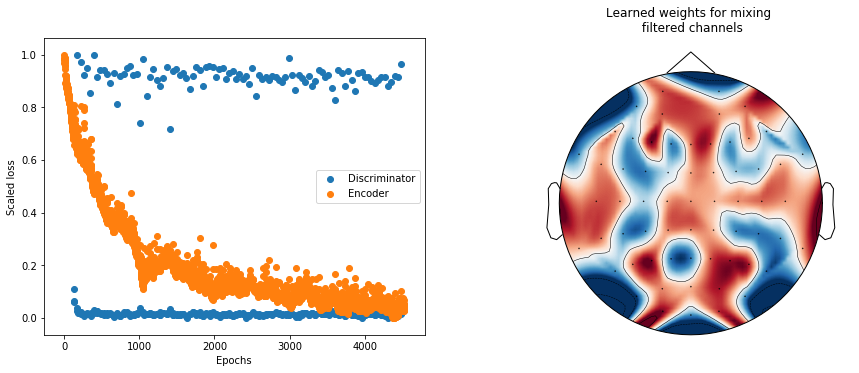

(<matplotlib.image.AxesImage at 0x7fab2c372a90>,
 <matplotlib.contour.QuadContourSet at 0x7fab2c3726d8>)

In [6]:
# load chanlocs:
layout_from_raw = pickle.load(open("/home/amplifier/home/DATASETS/Chanlocs-63.p", "rb"))

# get the weights that mix the filtered EEG channels:
act = gan.encoder.layers[1].get_weights()[1].squeeze()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.scatter(gan.discriminator_epochs[1:], preprocessing.minmax_scale(discriminator_loss[1:]))
ax1.scatter(gan.encoder_epochs, preprocessing.minmax_scale(encoder_loss))
ax1.legend(['Discriminator', 'Encoder'])
ax1.set_ylabel('Scaled loss')
ax1.set_xlabel('Epochs')

# # plot these weights:
ax2.set_title('Learned weights for mixing \n filtered channels')
mne.viz.plot_topomap(act, layout_from_raw.pos, axes=ax2)

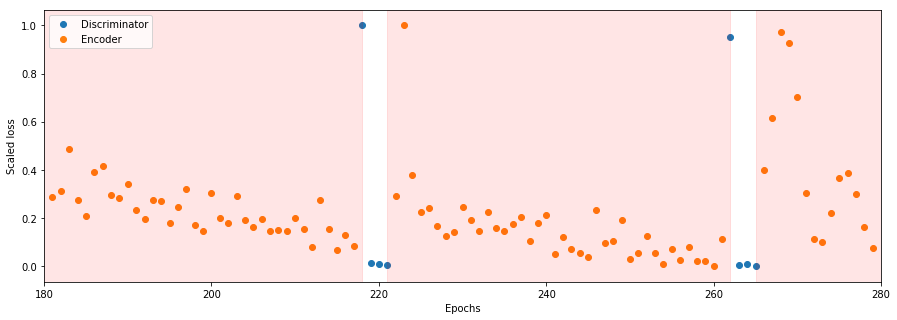

In [7]:
def get_enc_boundaries(inpt):
    l = len(inpt)
    v = inpt
    V1, V2 = [], []
    for i in range(1,l-1):
        if v[i+1]-v[i]>1:
            V1.append(v[i])
            V2.append(v[i+1])
    return V1, V2

st = 180
en = 280
de = np.array(gan.discriminator_epochs)
dl = np.array(discriminator_loss)
ee = np.array(gan.encoder_epochs)
el = np.array(encoder_loss)
de_ = de[np.logical_and(de>st, de<en)]
dl_ = dl[np.logical_and(de>st, de<en)]
ee_ = ee[np.logical_and(ee>st, ee<en)]
el_ = el[np.logical_and(ee>st, ee<en)]

plt.figure(figsize=(15,5))
plt.scatter(de_, preprocessing.minmax_scale(dl_))
plt.scatter(ee_, preprocessing.minmax_scale(el_))
plt.legend(['Discriminator', 'Encoder'])
plt.ylabel('Scaled loss')
plt.xlabel('Epochs')
plt.xlim(st,en)

V1, V2 = get_enc_boundaries(gan.discriminator_epochs)

for i in range(len(V1)):
    plt.axvspan(V1[i], V2[i], alpha=0.1, color='red')

In [83]:
##############################################################################################################################################################################
##############################################################################################################################################################################
##############################################################################################################################################################################
##############################################################################################################################################################################
##############################################################################################################################################################################
##############################################################################################################################################################################
##############################################################################################################################################################################

In [29]:
# gan = GAN()
def diag_discriminator_loss(x_train, x_test, y_train, y_test):
    plt.figure(figsize=(15,5))
    xx_train = np.arange(0,len(y_train))
    xx_test = np.arange(0,len(y_test))
    pred_true_train = gan.discriminator.predict(y_train)[:,0]
    pred_fake_train = gan.discriminator.predict(gan.encoder.predict(x_train))[:,0]
    pred_true_test = gan.discriminator.predict(y_test)[:,0]
    pred_fake_test = gan.discriminator.predict(gan.encoder.predict(x_test))[:,0]
    plt.plot(xx_train, pred_true_train)
    plt.plot(xx_train, pred_fake_train)
    plt.plot(xx_test, pred_true_test)
    plt.plot(xx_test, pred_fake_test)
    plt.legend(['discr. pred. label for reals_train',
                'discr. pred. label for fakes_train',
                'discr. pred. label for reals_test',
                'discr. pred. label for fakes_test'])
    
def diag_discriminator_loss2(gan, x_train, x_test, y_train, y_test):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    tst = gan.encoder.predict(x_train)
    pred_raw = gan.discriminator.predict(np.vstack([tst, y_train]))
    plt.plot(pred_raw[:,0])
    plt.title('Train set.\n correctly predicted fakes:{:.2f}\ncorrectly predicted reals:{:.2f}'.format(np.mean(gan.discriminator.predict(tst)[:,0]), np.mean(gan.discriminator.predict(y_train)[:,1])))
    plt.subplot(1,2,2)
    tst = gan.encoder.predict(x_test)
    pred_raw = gan.discriminator.predict(np.vstack([tst, y_test]))
    plt.plot(pred_raw[:,0])
    plt.title('Test set.\n correctly predicted fakes:{:.2f}\ncorrectly predicted reals:{:.2f}'.format(np.mean(gan.discriminator.predict(tst)[:,0]), np.mean(gan.discriminator.predict(y_test)[:,1])))

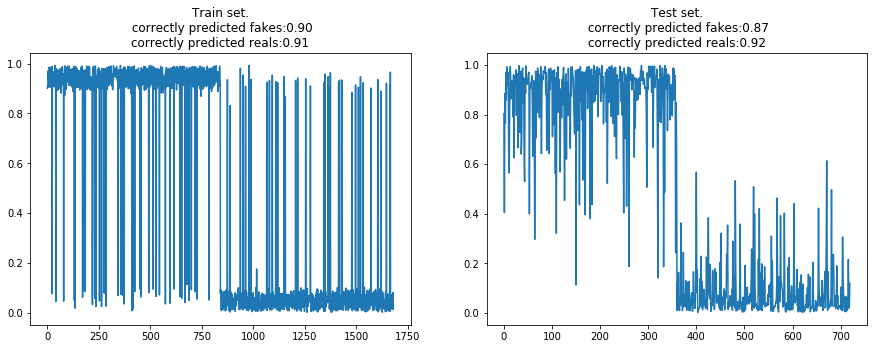

In [30]:
diag_discriminator_loss2(gan, x_train, x_test, y_train, y_test)

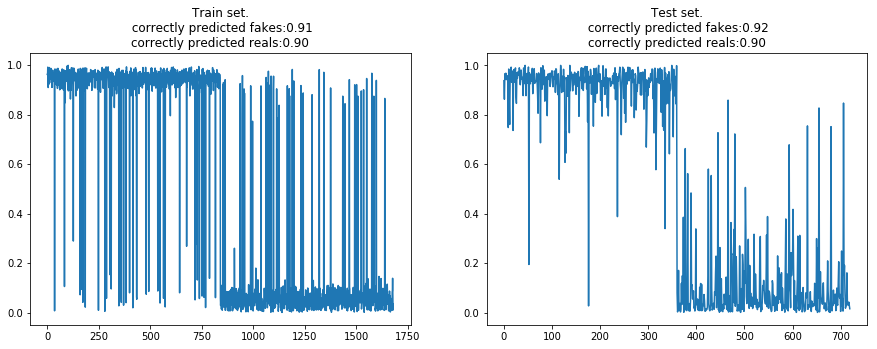

In [31]:
gan.FitDiscriminator(x_train, y_train, epochs=100, batch_size=400, verbose=0)
# diag_discriminator_loss(x_train, x_test, y_train, y_test)
diag_discriminator_loss2(gan, x_train, x_test, y_train, y_test)

Epoch 1/140
840/840 [==============================] - 7s 9ms/step - loss: 0.9503 - discriminator_loss: 0.1620 - encoder_loss: 0.7883
Epoch 2/140
840/840 [==============================] - 0s 167us/step - loss: 0.8744 - discriminator_loss: 0.0795 - encoder_loss: 0.7950
Epoch 3/140
840/840 [==============================] - 0s 166us/step - loss: 0.8621 - discriminator_loss: 0.0777 - encoder_loss: 0.7844
Epoch 4/140
840/840 [==============================] - 0s 159us/step - loss: 0.8436 - discriminator_loss: 0.0463 - encoder_loss: 0.7973
Epoch 5/140
840/840 [==============================] - 0s 155us/step - loss: 0.8553 - discriminator_loss: 0.0464 - encoder_loss: 0.8089
Epoch 6/140
840/840 [==============================] - 0s 156us/step - loss: 0.8354 - discriminator_loss: 0.0360 - encoder_loss: 0.7994
Epoch 7/140
840/840 [==============================] - 0s 156us/step - loss: 0.8217 - discriminator_loss: 0.0284 - encoder_loss: 0.7934
Epoch 8/140
840/840 [=============================

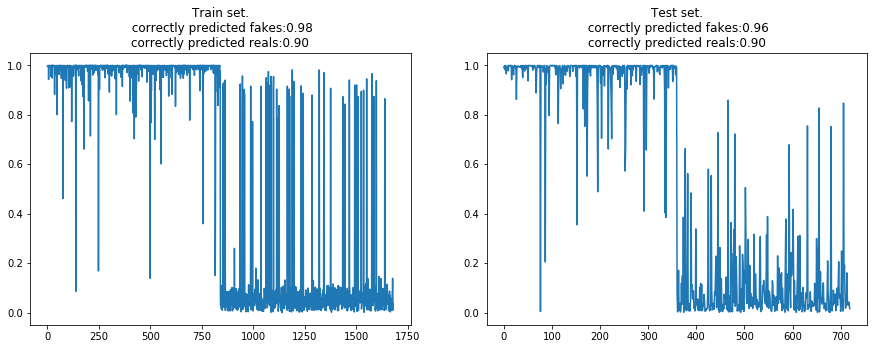

In [32]:
gan.FitEncoder(x_train, y_train, epochs=140, batch_size=400, verbose=1, loss_weights=[1, 1])
diag_discriminator_loss2(gan, x_train, x_test, y_train, y_test)

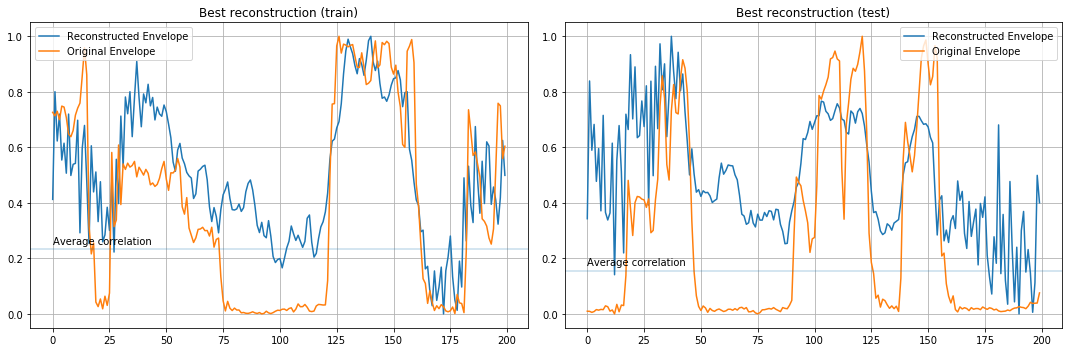

In [33]:
plt.figure(figsize=(15,5))
best_performer(x_train, y_train, gan.encoder, 'train')
best_performer(x_test, y_test, gan.encoder, 'test')

In [35]:
print(gan.discriminator.summary())
print(gan.encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 12)           612       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 24)           14424     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 24)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                115248    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 98        
Total para

In [70]:
gan.discriminator = gan.Discriminator()
gan.discriminator.compile(optimizer='adam', loss='binary_crossentropy')


In [25]:
encoder.layers[1].weights

[<tf.Variable 'separable_conv1d_5/depthwise_kernel:0' shape=(100, 63, 1) dtype=float32_ref>,
 <tf.Variable 'separable_conv1d_5/pointwise_kernel:0' shape=(1, 63, 1) dtype=float32_ref>,
 <tf.Variable 'separable_conv1d_5/bias:0' shape=(1,) dtype=float32_ref>]

In [22]:
encoder.layers[1].weights

[<tf.Variable 'separable_conv1d_4/depthwise_kernel:0' shape=(100, 63, 1) dtype=float32_ref>,
 <tf.Variable 'separable_conv1d_4/pointwise_kernel:0' shape=(1, 63, 63) dtype=float32_ref>,
 <tf.Variable 'separable_conv1d_4/bias:0' shape=(63,) dtype=float32_ref>]

In [4]:
print([i for i in encoder.layers[1].weights])
encoder.layers[2].weights

[<tf.Variable 'separable_conv1d_1/depthwise_kernel:0' shape=(100, 63, 1) dtype=float32_ref>, <tf.Variable 'separable_conv1d_1/pointwise_kernel:0' shape=(1, 63, 100) dtype=float32_ref>, <tf.Variable 'separable_conv1d_1/bias:0' shape=(100,) dtype=float32_ref>]


[<tf.Variable 'conv1d_3/kernel:0' shape=(1, 100, 1) dtype=float32_ref>,
 <tf.Variable 'conv1d_3/bias:0' shape=(1,) dtype=float32_ref>]

we have 60 1-D filters of length 200. We get kind of time-frequency and then we take a weighted sum (weights are given by the second weight matrix) or a set of weighted sums, depending on how many output channels we want. In this case we want 16.
![title](../DATASETS/DepthWiseSeprableConv.png)